# Tarea 2 - Regresion Polinomial & Feature engineering

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 6 de Junio. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

Filtraremos los datos para Guatemala, ya que son los que nos interesan y cambiaremos el tipo de dato de "Date" que es un string a date

In [13]:
covid = pd.read_csv("covid_19_clean_complete.csv")

covidGt = covid[(covid["Country/Region"] == "Guatemala") & (covid["Confirmed"] > 0)].copy()
covidGt["Date"] = pd.to_datetime(covidGt["Date"], infer_datetime_format = True)

In [ ]:
Graficamos los datos para tener una idea de como se comportan los datos de interes

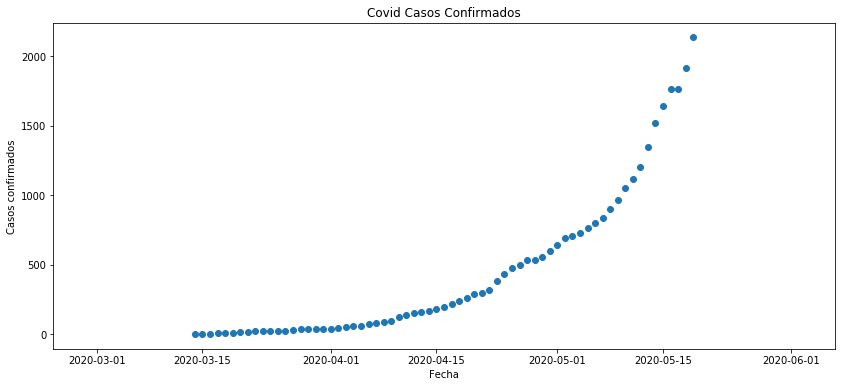

In [23]:
plt.figure(figsize = (14, 6))
plt.scatter(x = covidGt["Date"], y = covidGt["Confirmed"])

plt.title("Covid Casos Confirmados")
plt.xlabel("Fecha")
plt.ylabel("Casos confirmados")
plt.show()

Transformamos los datos de confirmed usando el logaritmo natural.

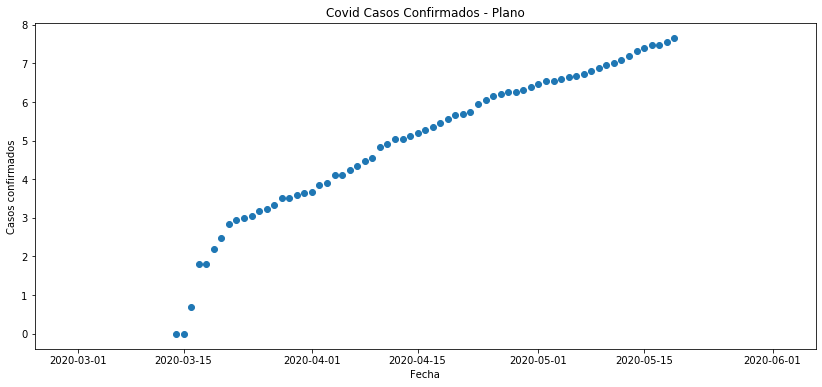

In [24]:
covidGt["ln_confirmed"] = np.log(covidGt["Confirmed"])

plt.figure(figsize = (14, 6))
plt.scatter(x = covidGt["Date"], y = covidGt["ln_confirmed"])
plt.title("Covid Casos Confirmados - Plano")
plt.xlabel("Fecha")
plt.ylabel("Casos confirmados")
plt.show()

Los primeros 7 elementos de la data parecen no ayudar al módelo, todos estos pertenecen a un ln(confirmed) < 2.5, así que eliminaremos a estos.
También transformamos la fecha, en vez de usar la fecha usaremos el número de día.

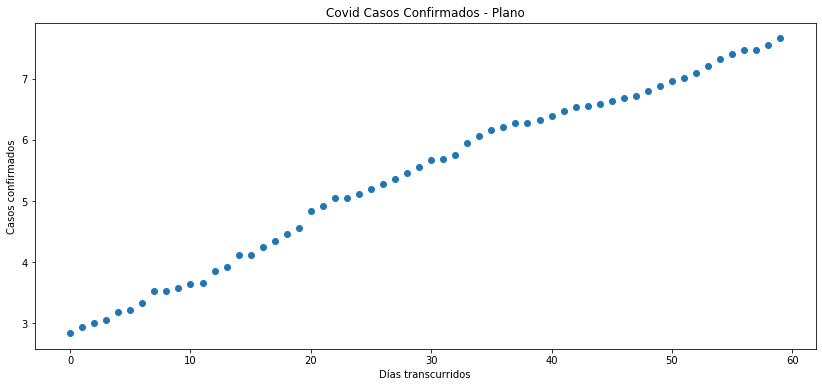

In [31]:
covidGt = covidGt[(covidGt["ln_confirmed"] > 2.5)].copy()
covidGt["day"] = np.arange(len(covidGt))

plt.figure(figsize = (14, 6))
plt.scatter(x = covidGt["day"], y = covidGt["ln_confirmed"])
plt.title("Covid Casos Confirmados - Plano")
plt.xlabel("Días transcurridos")
plt.ylabel("Casos confirmados")
plt.show()

Creación del módelo gradient descent, igual al del laboratorio pasado.

In [46]:
def gradient_descent(x, y, epochs, lr, print_rate=100):
    tf.reset_default_graph()
    
    with tf.name_scope("input"):
        x = tf.concat([x, tf.ones_like(x)], axis = 1)
    with tf.name_scope("params"):
        params = tf.Variable(name="params", initial_value = tf.zeros((2, 1), tf.float64))
    with tf.name_scope("predict"):
        y_hat = tf.matmul(x, params)
    with tf.name_scope("error"):
        error = 1/2 * tf.reduce_mean(tf.math.square(y - y_hat))
    with tf.name_scope("gradient"):
        gradients = tf.gradients(error, params)
    with tf.name_scope("update_model"):
        fit = tf.scalar_mul(-lr, gradients[0])
        update_model = tf.assign(params, tf.add(params, fit))


    with tf.Session() as session:
        summary = tf.summary.scalar(name = "error_epochs", tensor = error)
        writer = tf.summary.FileWriter("./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr=" + str(lr) + "_epochs=" + str(epochs), session.graph)
        session.run(tf.global_variables_initializer())
        for epoch in range(0, epochs):
            if ((epoch + 1) % print_rate) == 0:
                print("error: " + str(session.run(error)))
      
            writer.add_summary(session.run(summary), epoch)
            session.run(update_model)

        params = session.run(params)

        writer.close()
    session.close()

    return params[0][0], params[1][0]


In [47]:
x = np.array(covidGt["day"], dtype = float).reshape(-1, 1)
y = np.array(covidGt["ln_confirmed"]).reshape(-1, 1)

In [61]:
epochs = 15000
m, b = gradient_descent(x, y, 15000, 0.0017, epochs / 5)

error: 0.095408125391662
error: 0.018585920991864822
error: 0.012954848982381894
error: 0.01254209107958907
error: 0.012511835901528627


Con un learning rate mayor a 0.0017 el módelo diverge, y con un learning rate mayor el módelo se tarda más en converger. 
Después de las 15,000 iteraciones no parece haber mucho cambio en el error.

In [64]:
print("pendiente = " + str(m))
print("intercepto = " + str(b))

pendiente = 0.08275469701349958
intercepto = 2.9690684556021965


In [68]:
day = (datetime.datetime.strptime("2020-06-06","%Y-%m-%d") - covidGt.iloc[0]["Date"]).days
y_hat = np.exp(m * day + b)
print(y_hat)

11397.851202893358


Con esto podemos decir que esperamos una cantidad de 11398 casos para el 6 de junio (77 días después).

### Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('winequality-red.csv')

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
